#OA3892 Lab 3: Thesis Matching (MongoDB)
###Travis Farwell

This lab involves pulling collections from a MongoDB and finding top thesis matches to sample abstracts. It will involving tokenizing 30630 past NPS theses and creating a Document Term Matrix which will be used to calculate a Similarity Matrix that can be used to show how similar a document is to another.

##Task 1: Comparing Text Analytic Techniques and Similarity Vectorization Calculations

The code block below loads several libraries which will be used for various computations throughout this tutorial. The mongo() function connects us to the database and the summaries collection which was preloaded. The prep_fun() function is used to do text processing on character strings. It first make all the characters lowercase, then replaces all punctuation with the '[:alnum:]' regex. Spaces are collapsed just before turning the vector into a corpus using the tm library. The function includes decision statements to remove stopwords and stem the words. Finally, the corpus is converted to a vector of strings by unlisting in the for loop.

In [3]:
library(mongolite)
library(text2vec)
library(tm)
library(readr)
library(SnowballC)
library(stringr)

my_collection <- mongo(collection="summaries", db = "nps_theses")

prep_fun = function(x, removeStops=T, stem=T) {
    
    # make text lower case
    x <- str_to_lower(x) 
    # remove non-alphanumeric symbols
    x <- str_replace_all(x, "[^[:alnum:]]", " ")
    # collapse multiple spaces
    x <- str_replace_all(x,"\\s+", " ")
    # create corpus
    Corp <- VCorpus(VectorSource(x))
    # remove stopwords?
    if(removeStops){Corp <- tm_map(Corp, removeWords, stopwords("english"))}
    # stem words?
    if(stem){Corp <- tm_map(Corp, stemDocument)}
    # turn corpus back to character strings
    for(i in 1:length(Corp)) {x[i] <- as.character(Corp[[i]])}
    x
}

The function matches() will take a similarity matrix and count the number of max values in the diaganols. This is a helper function that will be used to decide which combination of text processing and similarity algorithms work better. Both the thesis abstracts and titles will be pulled from the database. They will be computed to created a 30360 by 30360 matrix of similarity measurements. Each diagonal will represent the score between each abstract and it's title. In theory, the title of the thesis should be similar to it's abstract. 

In [4]:
matches <- function(sim.matrix){
  num = c()
  max.each.col <- apply(sim.matrix,2,max)
  for(i in 1:nrow(sim.matrix)) {
    if((sim.matrix[i,i] == max.each.col[i]))
      num <- c(num,1)
    else
      num <- c(num,0)
  }
  print(mean(num))
}

The below code will evaluate 12 different combinations. Stemming, stopwords, and if\*tfd will be either present in the processing or not. The algorithm will toggle between cosine similarity and jaccard. Inside the for loop is where the abstracts and titles are processed by calling the prep_fun function. The vocabulary is created using the abstract strings. N-grams of size 2 will be created and be used default throughout the analysis. The string vectors are turned into document term matrices and possibly transformed by if\*tfd. Then a similarity matrix is computed and the number of diagonal matches is used as a metric to see how well the processing/algorithm combination performed.

In [ ]:
#create combination dataframe
df <- expand.grid(T:F, T:F, c("cosine","jaccard"), T:F)
names(df) <- c("Stem?","Remove_Stops","Sim","if*tfd")
dataframe <- data.frame(my_collection$find(fields = '{"_id":0, "abstract":1}'))
title.df <- data.frame(my_collection$find(fields = '{"_id":0, "title":1}'))
for(i in 1:12){
  
  #process abstracts
  dataframe$abstracts_clean <- prep_fun(dataframe$abstract,df[i,1],df[i,2])
  it = itoken(dataframe$abstracts_clean, progressbar = F)
  
  #create vocab from tokens and prune. N-grams = 1, 2
  v = create_vocabulary(it, ngram = c(1L,2L)) %>% prune_vocabulary(doc_proportion_max = 0.1, term_count_min = 3)
  vectorizer = vocab_vectorizer(v)
  #abtract dtm
  dtm = create_dtm(it, vectorizer)
  #process titles
  title.df$title_clean <- prep_fun(title.df$title,df[i,1],df[i,2])
  it_titles = itoken(title.df$title_clean, progressbar = F)
  #titles dtm  
  dtm_titles = create_dtm(it_titles,vectorizer)
  #transform if*tfd?
  if(df[i,4]){
    tfidf = TfIdf$new()
    dtm = fit_transform(dtm, tfidf)

    dtm_titles = fit_transform(dtm_titles, tfidf)
  }
  #created similarity matrix
  dtm_sim = sim2(dtm[1:3000,],dtm_titles[1:3000,], method = as.character(df[i,3]), norm = "l2")
  
  #find the number of title matches to abstracts  
  df$matches[i] <- matches(dtm_sim)

}


We can see how well each combination performed. Cosine performed very well when if\*tfd DTM was used. There is no difference for jaccard when if\*tfd is used. Removing stopwords increased average hit by about 3%. Using stemming helped when jaccard was used and stopwords were removed.

In [90]:
print(df[1:12,])

   Stem? Remove_Stops     Sim if*tfd   matches
1      1            1  cosine      1 0.6836667
2      0            1  cosine      1 0.6846667
3      1            0  cosine      1 0.6693333
4      0            0  cosine      1 0.6700000
5      1            1 jaccard      1 0.5830000
6      0            1 jaccard      1 0.5536667
7      1            0 jaccard      1 0.5406667
8      0            0 jaccard      1 0.5396667
9      1            1  cosine      0 0.6426667
10     0            1  cosine      0 0.6406667
11     1            0  cosine      0 0.6060000
12     0            0  cosine      0 0.6130000


Finding the max similarity score for the first 5 titles and printing out the first 5 abstract and titles. Titles are columns and abstracts are rows. This will allow us to see how abstracts compare to titles that were not an exact match. Titles 2, 3, 4 and 5 all had best similarity measurements which matched to it's abstract.

In [25]:
apply(dtm_sim[,1:5],2,max)
dtm_sim[1:5,1:5]

1         2         3         4         5 
0.1948127 0.3056426 0.2869255 0.2155836 0.4482504

5 x 5 sparse Matrix of class "dgCMatrix"
           1           2           3           4           5
1 0.02994818 0.005579125 0.003906372 0.010678793 0.006814131
2 .          0.305642628 .           .           .          
3 .          0.004395548 0.286925455 .           .          
4 0.02456357 .           0.011609936 0.215583574 .          
5 .          0.015399179 .           0.006556684 0.448250401

The higher the similarity score the better the hit. The third title/abstract was a strong match but not an exact one. Printing out the title and abstract below demonstrates.

In [26]:
title.df$title[1]
dataframe$abstract[1]

[1] "Prioritization of Information Assurance (IA) technology in a resource constrained environment"

[1] "Classical risk analysis is a static process that does not account for rapid evolutionary or generational changes in technology and technological solutions. This thesis defines a process that expands classical risk analysis to increase visualization of the security environment of an information system. It provides a comparative analysis of system attributes and encourages focused communications between decision-makers and information systems technicians. Personal interviews with domain experts from four organizations were used to construct a baseline model. Face validity of the model was determined during sessions with the domain experts. The model was calibrated to two specific scenarios using a pair of surveys to set link values and establish data for the initial nodes. A verification phase compared rough results from the model with expert opinion. The model evaluated, prioritized and graphically illustrated shortfalls within two information systems based on the relative importance of specific criteria established by the domain experts. It facilitated the extraction of implicit or tacit knowledge from the domain experts that would not emerge during a classical risk analysis."

The first title did not match it's abstract very well above having a score of only 0.029. We will find the abstract with the max score below. The title and abstract both contain the phrase resource constrained giving it a higher score.

In [27]:
title.df$title[1]
dataframe$abstract[which(dtm_sim[,1] == max(dtm_sim[,1]))] 

[1] "Prioritization of Information Assurance (IA) technology in a resource constrained environment"

[1] "Hastily Formed Networks (HFNs) are typically deployed in resource constrained environments. Clients operating within HFNs have inadvertently utilized excessive bandwidth without user interaction. Our research focuses on managing bandwidth usage in resource constrained networks through the use of DNS Tampering, a method of content filtering. We evaluate two operating systems, Windows XP and Windows 7, and analyze how it may be possible to limit operating system updates utilizing DNS Tampering. We then explore how it may be possible to implement this technique utilizing equipment available for an HFN. Through our efforts, we develop and set forth specific methodologies that can provide the opportunity to limit bandwidth usage for specific applications in resource constrained networks."

Now the 16 sample abstracts will be loaded into a vector of strings. I have decided to use a blend of both cosine and jaccard algorithm. Ensembles typically perform better than single algorithm on their own. The sample abstracts and document abstracts from the mongo database are processed by removing stopwords, stemming, and using up to 2 N-grams. Then 2 similarity matrices are calculated, one using cosine and the other jaccard, and average together using vectorization. 

In [6]:
sample_abstracts <- c()
for(i in 1:16){
  filename <- paste("SampleProposals/W17_",i,".txt",sep = "")
  sample_abstracts[i] <- read_file(filename)
}


In [ ]:
dataframe <- data.frame(my_collection$find(fields = '{"_id":0, "abstract":1}'))
dataframe$abstracts_clean <- prep_fun(dataframe$abstract,T,T)
it = itoken(dataframe$abstracts_clean, progressbar = F)

#create vocab from tokens and prune. N-grams = 1, 2
v = create_vocabulary(it, ngram = c(1L,2L)) %>% prune_vocabulary(doc_proportion_max = 0.1, term_count_min = 3)
vectorizer = vocab_vectorizer(v)
#abtract dtm
dtm = create_dtm(it, vectorizer)
#process titles
samples_clean <- prep_fun(sample_abstracts)
it_samp = itoken(samples_clean, progressbar = F)
dtm_samp = create_dtm(it_samp,vectorizer)

tfidf = TfIdf$new()
dtm = fit_transform(dtm, tfidf)
dtm_samp = fit_transform(dtm_samp, tfidf)

#created similarity matrix
sim_cosine = sim2(dtm,dtm_samp, method = "cosine", norm = "l2")
sim_jaccard = sim2(dtm,dtm_samp, method = "jaccard")
sim_mix = (sim_cosine + sim_jaccard)/2

Printing out the 5th sample abstract and the matching abstract by finding the max value of the 5th column of the similarity matrix. Reading the abstracts confirms that they are similar in to each other. 

In [13]:
sample_abstracts[5]
dataframe$abstract[which(sim_mix[,5] == max(sim_mix[,5]))] 

[1] "Talent management is a current, relevant issue military unit leaders face. The number of human resources available--particularly those with beneficial or required experiences and skills--are limited, and as a result leaders must invest deliberate thought and consideration into how they build teams fit for the missions at hand. Army units, depending upon their sizes, capabilities, and budgets, have an array of available talent management tools to help leaders optimize whom they hire and where they put these people. However, unless the unit is at the regiment level or higher, many of these tools are limited in scope to job highly generalized, and often embellished, performance reports and experience resumes."

[1] "U.S. Army officers face countless opportunity costs, especially at the mid-grade level, when deciding to stay in the Army past the ten-year mark of service. The scarcity of skilled labor in today_��s economy makes it important that organizations, especially the Army, retain their human capital investment. This thesis suggests techniques to acquire, manage, and retain talent to ensure that the Army_��s officer talent pool is not depleted. Some of the best corporate talent management practices are examined as an example for the Army to emulate. The thesis reinforces these proven techniques by examining corporate case studies, including General Electric and its leadership development, Sambian and its engagement, American Express and its use of talent profiles, and Facebook and its recruitment and retention practices. The thesis then examines current Army initiatives for future accession, development, retention, and employment of officer talent. The thesis concludes with recommendations for Army talent management to include an officer talent profile system that would increase officer engagement and hold leadership accountable for the retention of its officers."

##Task 2: Develop a Visualization for the User of Your Algorithm’s Answer
Using sample abstract number 16 as and example we can find how well the top 20 database abstracts matched to the top 20 if\*tfd weighted words. To find the top 20 similar abstracts we sort the ith column of the similarity matrix (sim_mix) in decreasing fashion. These are indexed 1 to 20 to keep only the top 20. Then we store the names of the rows which represent the document number. A similar computation is performed to find the top 20 terms for the sample abstract. This time the ith row is sorted. The columns represent the terms. The names are stored to use for indexing. The document term matrix is indexed using the top 20 similar documents and terms to create a twenty by twenty matrix representing the if\*tfd values for the terms of the top 20 documents. This matrix is used to create a heatmap so the user can see the 20 documents and how they relate to the user's abstract. 

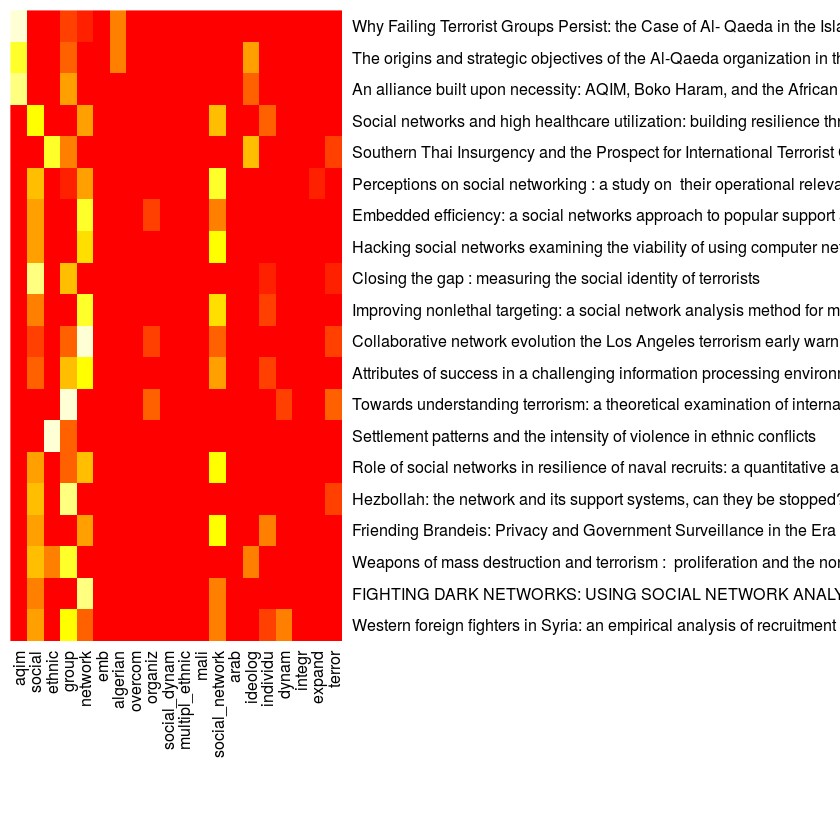

In [16]:
#using sample number 16 as example
sample.num <- 16
title.df <- data.frame(my_collection$find(fields = '{"_id":0, "title":1}'))
#Returns which documents are most similar to 1st sample document
top_20_similar <- names(sort(sim_mix[,sample.num],decreasing=T)[1:20])
#Returns top 20 terms of 1st sample documents
top_20_terms <- names(sort(dtm_samp[sample.num,],decreasing=T)[1:20])

top_sim_matrix <- dtm[top_20_similar,top_20_terms]
par(mar=c(1,1,1,1))
heatmap(data.matrix(top_sim_matrix),Rowv=NA,Colv=NA,labRow = title.df[top_20_similar,],margins = c(10,25),revC = T)

##Task 3: Develop a Report/Interface for Users to Access the Recommended Thesis Documents

Using the top_20_similar vector from task 2, we can find the titles and http hyperlinks to create a table that the user can use to fetch the desired theses. First the hyperlinks are extracted and stored from the database. A dataframe is created using the top 20 titles and similarity scores which are indexed from the names of the top_20_similar vector. The Title column is then transfomed using paste to create html strings with the hyperlinks embedded. Using the googleVis library a gvisTable object is created that helps create the frontend html for the table. The IRdisplay library is used only to help display html in jupyter notebook which had to be saved to a file and called. 


In [19]:
library(googleVis)
library(IRdisplay)
links<- data.frame(my_collection$find(fields = '{"_id":0, "identifier":1}'))

table <- data.frame(Title=title.df[top_20_similar,],Similarity= sim_mix[top_20_similar,16])
table <- transform(table, Title = paste('<a href = ', shQuote(links[top_20_similar,]), '>', title.df[top_20_similar,], '</a>')) 
x = gvisTable(table, options = list(allowHTML = TRUE))
display_html(file="table.html")


Title,Similarity
Why Failing Terrorist Groups Persist: the Case of Al- Qaeda in the Islamic Maghreb,0.205
The origins and strategic objectives of the Al-Qaeda organization in the Islamic Maghreb (AQIM).The origins and strategic objectives of the Al Qaeda organization in the Islamic Maghreb (AQIM),0.127
"An alliance built upon necessity: AQIM, Boko Haram, and the African ""arch of instability""",0.121
Social networks and high healthcare utilization: building resilience through analysis,0.102
Southern Thai Insurgency and the Prospect for International Terrorist Group Involvement,0.101
Perceptions on social networking : a study on their operational relevance for the Navy,0.099
Embedded efficiency: a social networks approach to popular support and dark network structure,0.099
Hacking social networks examining the viability of using computer network attack against social networks,0.098
Closing the gap : measuring the social identity of terrorists,0.093
Improving nonlethal targeting: a social network analysis method for military planners,0.093
